In [1]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 660.5 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2
import random
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D

In [3]:
train_path ='../input/autism-image-data/AutismDataset/train/'
test_path = '../input/autism-image-data/AutismDataset/test/'

In [4]:
file_names = np.array(os.listdir(train_path))
lable_name = []
file_path = []
for filename in file_names:
    category = filename.split('.')[0]
    file_path.append(train_path+ filename)
    if category == 'Autistic':
        lable_name.append('Autistic')
    else:
        lable_name.append('Non_Autistic')
train_df = pd.DataFrame({
    'file_path': file_path,
    'label_name': lable_name
})


In [5]:
file_names_test = np.array(os.listdir(test_path))
lable_name_test = []
file_path_test = []
for filename in file_names_test:
    category = filename.split('.')[0]
    file_path_test.append(train_path+ filename)
    if category == 'Autistic':
        lable_name_test.append('Autistic')
    else:
        lable_name_test.append('Non_Autistic')
test_df = pd.DataFrame({
    'file_path': file_path_test,
    'label_name': lable_name_test
})


In [6]:
train_df.head()

,file_path,label_name
0,../input/autism-image-data/AutismDataset/train...,Non_Autistic
1,../input/autism-image-data/AutismDataset/train...,Autistic
2,../input/autism-image-data/AutismDataset/train...,Non_Autistic
3,../input/autism-image-data/AutismDataset/train...,Autistic
4,../input/autism-image-data/AutismDataset/train...,Non_Autistic


In [7]:
test_df.head()

,file_path,label_name
0,../input/autism-image-data/AutismDataset/train...,Non_Autistic
1,../input/autism-image-data/AutismDataset/train...,Autistic
2,../input/autism-image-data/AutismDataset/train...,Autistic
3,../input/autism-image-data/AutismDataset/train...,Autistic
4,../input/autism-image-data/AutismDataset/train...,Non_Autistic


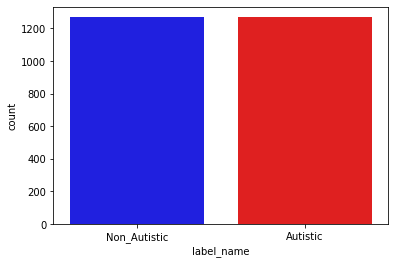

In [8]:
sns.set_palette(sns.color_palette(["b", "r"]))
sns.countplot(x =train_df['label_name'])
plt.show()

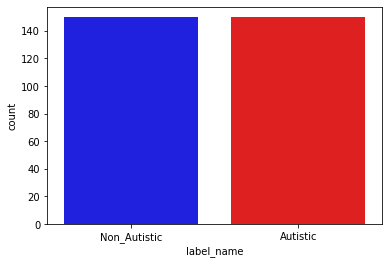

In [9]:
sns.set_palette(sns.color_palette(["b", "r"]))
sns.countplot(x =test_df['label_name'])
plt.show()

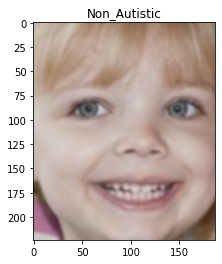

In [10]:
sample = random.choice(file_path)
image = plt.imread(sample)
plt.title(sample.split('/')[-1].split('.')[0])
plt.imshow(image)
plt.show()

In [11]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [12]:
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 30
batch_size = 20

In [13]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_train,total_validate

(2286, 254)

In [14]:
train_df.head()

,index,file_path,label_name
0,1568,../input/autism-image-data/AutismDataset/train...,Non_Autistic
1,224,../input/autism-image-data/AutismDataset/train...,Non_Autistic
2,2105,../input/autism-image-data/AutismDataset/train...,Non_Autistic
3,610,../input/autism-image-data/AutismDataset/train...,Non_Autistic
4,814,../input/autism-image-data/AutismDataset/train...,Autistic


In [15]:
validate_df.head()

,index,file_path,label_name
0,1484,../input/autism-image-data/AutismDataset/train...,Autistic
1,1782,../input/autism-image-data/AutismDataset/train...,Autistic
2,822,../input/autism-image-data/AutismDataset/train...,Autistic
3,2397,../input/autism-image-data/AutismDataset/train...,Autistic
4,1283,../input/autism-image-data/AutismDataset/train...,Non_Autistic


In [16]:
train_set = train_gen.flow_from_dataframe(
    train_df, 
    x_col='file_path',
    y_col='label_name',
    target_size=(image_size,image_size), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=batch_size)
val_set = val_gen.flow_from_dataframe(
    validate_df, 
    x_col='file_path',
    y_col='label_name',
    target_size=(image_size,image_size), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=batch_size)

Found 2286 validated image filenames belonging to 2 classes.
Found 254 validated image filenames belonging to 2 classes.


In [17]:
class_dict = {v:k for k,v in train_set.class_indices.items()}
class_dict

{0: 'Autistic', 1: 'Non_Autistic'}

In [18]:
train_set.image_shape,val_set.image_shape

((224, 224, 3), (224, 224, 3))

In [19]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

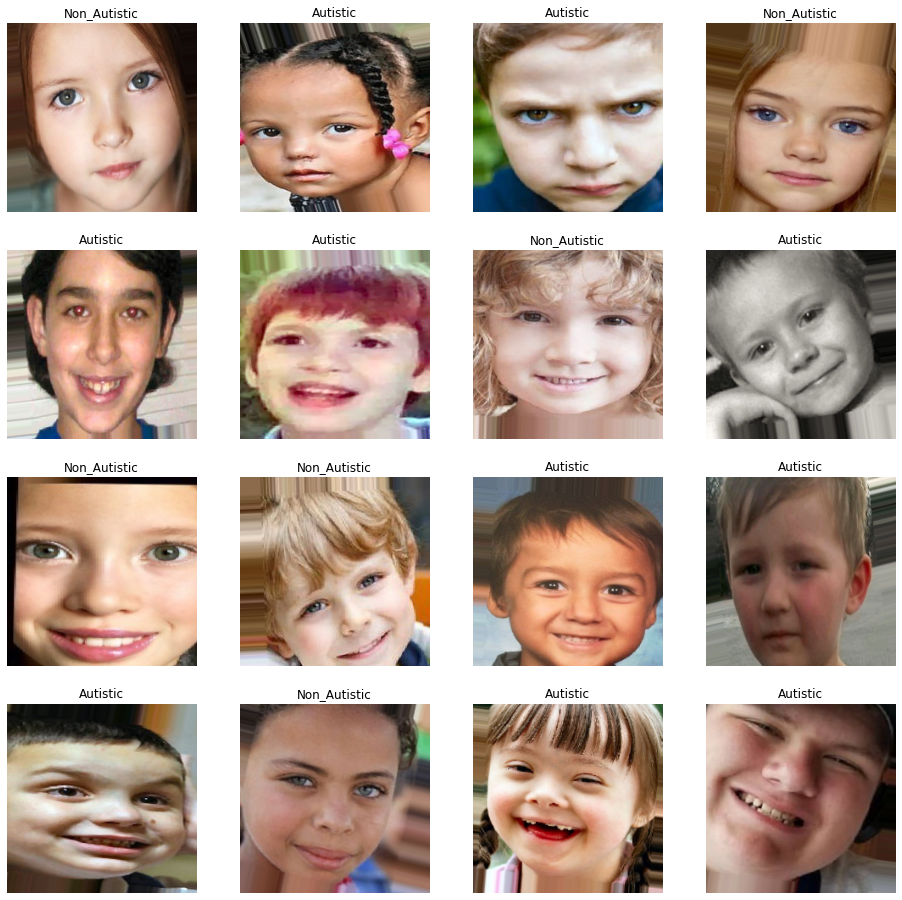

In [20]:
see_examples(train_set)

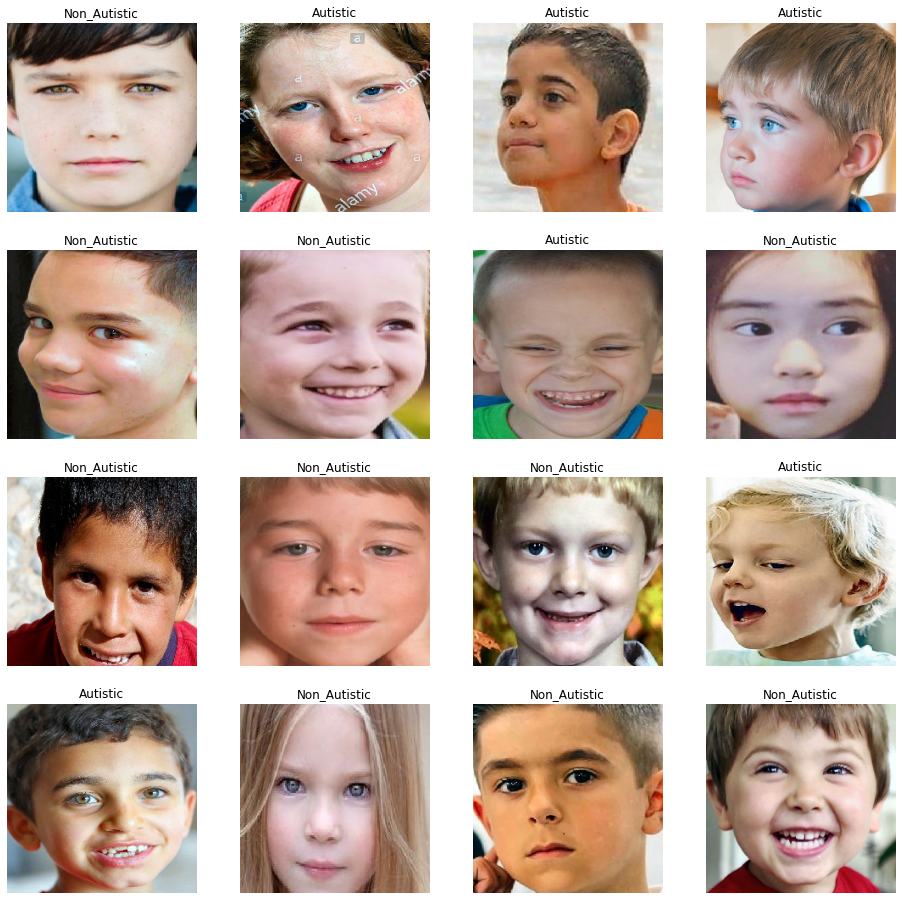

In [21]:
see_examples(val_set)

In [22]:
conv_base = efn.EfficientNetB0(input_shape=input_shape, include_top=False, weights="imagenet")
conv_base.trainable=True 

2022-10-09 18:08:41.053671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 18:08:41.148239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 18:08:41.149799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 18:08:41.158880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16818176/16804768 [==============================] - 0s 0us/step


In [23]:
# conv_base = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
# conv_base.trainable=False 

In [24]:
input_shape

(224, 224, 3)

In [25]:
conv_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [26]:
# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block6a_expand_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False 

# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False 

In [27]:
model = Sequential([
    conv_base,
    GlobalMaxPooling2D(),
    
    Dense(units=512,activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [29]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=10),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

metrics = [
    CategoricalAccuracy(), 
#     F1Score(num_classes=2), 
#     Precision(), 
#     Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [30]:
history = model.fit_generator(train_set,epochs=epochs, steps_per_epoch=total_train//batch_size,
                  validation_data=val_set, validation_steps=total_validate//batch_size,callbacks= callbacks
                             )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-09 18:08:48.430718: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-10-09 18:08:57.358643: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


114/114 [==============================] - 61s 404ms/step - loss: 0.7350 - categorical_accuracy: 0.6889 - val_loss: 0.7836 - val_categorical_accuracy: 0.6542


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
114/114 [==============================] - 37s 322ms/step - loss: 0.4684 - categorical_accuracy: 0.7979 - val_loss: 3.4871 - val_categorical_accuracy: 0.5167
Epoch 3/30
114/114 [==============================] - 37s 326ms/step - loss: 0.4149 - categorical_accuracy: 0.8169 - val_loss: 0.6939 - val_categorical_accuracy: 0.7833
Epoch 4/30
114/114 [==============================] - 37s 322ms/step - loss: 0.3562 - categorical_accuracy: 0.8416 - val_loss: 0.4058 - val_categorical_accuracy: 0.8333
Epoch 5/30
114/114 [==============================] - 37s 326ms/step - loss: 0.3798 - categorical_accuracy: 0.8517 - val_loss: 0.4880 - val_categorical_accuracy: 0.8042
Epoch 6/30
114/114 [==============================] - 37s 325ms/step - loss: 0.3207 - categorical_accuracy: 0.8654 - val_loss: 0.6430 - val_categorical_accuracy: 0.7625
Epoch 7/30
114/114 [==============================] - 37s 323ms/step - loss: 0.3487 - categorical_accuracy: 0.8522 - val_loss: 1.0139 - val_categorical_acc

In [31]:
# pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
# last_layer = pre_trained_model.get_layer('block5_pool')
# last_output = last_layer.output

# # Flatten the output layer to 1 dimension
# x = GlobalMaxPooling2D()(last_output)
# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.5
# x = Dropout(0.5)(x)
# # Add a final sigmoid layer for classification
# x = Dense(1, activation='sigmoid')(x)

# model = Model(pre_trained_model.input, x)

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=metrics)

# model.summary()

In [32]:
# history = model.fit_generator(
#     train_set,
#     epochs=epochs,
#     validation_data=val_set,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks= callbacks)

In [33]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,0.734981,0.688879,0.783606,0.654167
1,0.468427,0.797882,3.487113,0.516667
2,0.414947,0.816858,0.693911,0.783333
3,0.356155,0.841571,0.405785,0.833333
4,0.379754,0.851721,0.487969,0.804167


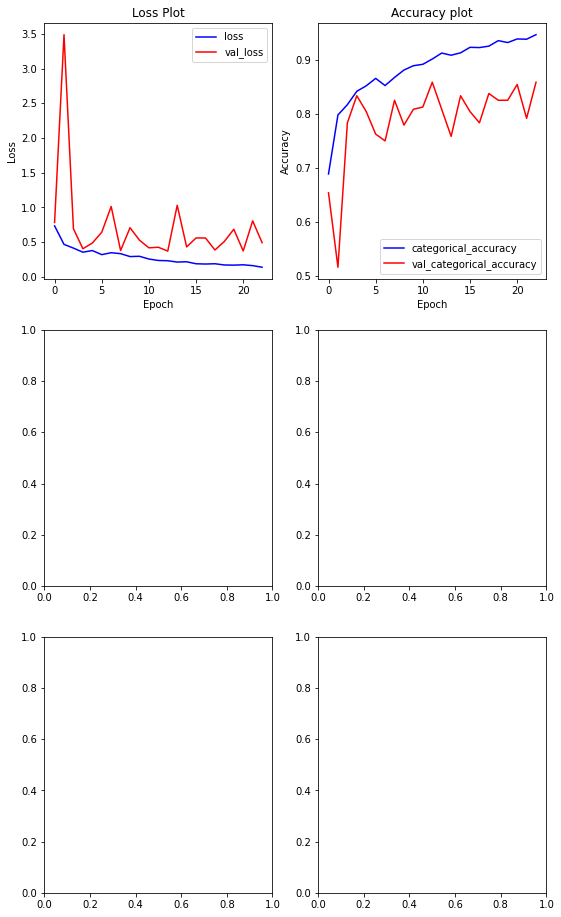

In [34]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
plt.show()

In [35]:
val_set_final = val_gen.flow_from_dataframe(
    test_df,x_col='file_path',
    y_col='label_name',
    class_mode='categorical',
    target_size=(image_size,image_size), 
    batch_size=batch_size, 
    shuffle=False)

Found 300 validated image filenames belonging to 2 classes.


In [36]:
best_model = load_model('best_model.h5')

In [37]:
val_loss,val_acc = best_model.evaluate(val_set_final)
val_preds = best_model.predict(val_set_final)
val_preds = val_preds.argmax(axis=1)
test_df.head()

15/15 [==============================] - 2s 81ms/step - loss: 0.2569 - categorical_accuracy: 0.8933


,file_path,label_name
0,../input/autism-image-data/AutismDataset/train...,Non_Autistic
1,../input/autism-image-data/AutismDataset/train...,Autistic
2,../input/autism-image-data/AutismDataset/train...,Autistic
3,../input/autism-image-data/AutismDataset/train...,Autistic
4,../input/autism-image-data/AutismDataset/train...,Non_Autistic


In [38]:
val_set.class_indices

{'Autistic': 0, 'Non_Autistic': 1}

In [39]:
test_df['Label'] = test_df['label_name'].map(val_set.class_indices)
test_df['Predicted'] = val_preds
test_df.head()

,file_path,label_name,Label,Predicted
0,../input/autism-image-data/AutismDataset/train...,Non_Autistic,1,1
1,../input/autism-image-data/AutismDataset/train...,Autistic,0,0
2,../input/autism-image-data/AutismDataset/train...,Autistic,0,0
3,../input/autism-image-data/AutismDataset/train...,Autistic,0,0
4,../input/autism-image-data/AutismDataset/train...,Non_Autistic,1,1


In [40]:
conf_mat = confusion_matrix(y_true=test_df['Label'], y_pred=test_df['Predicted'])
conf_mat = pd.DataFrame(conf_mat, index=val_set_final.class_indices.keys(), columns=val_set_final.class_indices.keys())

In [41]:
conf_mat

,Autistic,Non_Autistic
Autistic,125,25
Non_Autistic,7,143


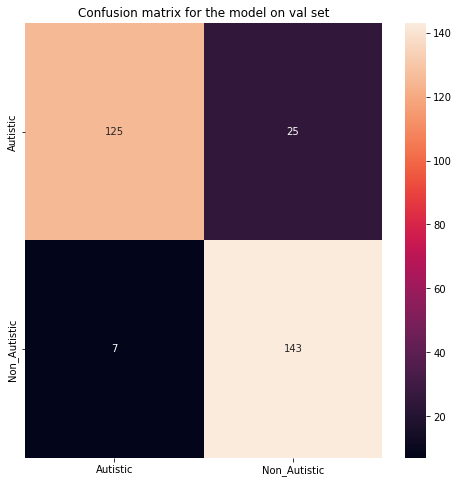

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on val set')
plt.show()